In [1]:
import os
import socket
from pyspark import SparkConf, SparkContext, SQLContext
from pyspark.sql import types as T, functions as F, SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, regexp_extract
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, ArrayType, BinaryType
from pyspark.ml.linalg import DenseVector, VectorUDT
from pyspark.ml.image import ImageSchema
from pyspark import StorageLevel
from jinja2 import Environment, FileSystemLoader
import datetime
import json

from PIL import Image, ImageDraw
import numpy as np
import pandas as pd
from typing import Iterator
import glob

In [23]:
LOGIN = "vsakovskaja-370052"  # Your gateway.st login
APP_NAME = "mushrooms"  # Any name for your Spark-app
DATA_PATH = "hdfs:///home/vsakovskaja-370052/data" # Full path to the dataset
OUTPUT_PATH = "hdfs:///home/vsakovskaja-370052/output.parquet" # Full path to the dataset

In [3]:
NORMALIZED_APP_NAME = APP_NAME.replace('/', '_').replace(':', '_').replace(' ', '_').replace('\\', '_')

APPS_TMP_DIR = os.path.join(os.getcwd(), "tmp")
APPS_CONF_DIR = os.path.join(os.getcwd(), "conf")
APPS_LOGS_DIR = os.path.join(os.getcwd(), "logs")
LOG4J_PROP_FILE = os.path.join(APPS_CONF_DIR, "pyspark-log4j-{}.properties".format(NORMALIZED_APP_NAME))
LOG_FILE = os.path.join(APPS_LOGS_DIR, 'pyspark-{}.log'.format(NORMALIZED_APP_NAME))
EXTRA_JAVA_OPTIONS = (
    "-Dlog4j.configuration=file://{} "
    "-Dspark.hadoop.dfs.replication=1 "
    "-Dhttps.protocols=TLSv1.0,TLSv1.1,TLSv1.2,TLSv1.3"
    .format(LOG4J_PROP_FILE)
)

LOCAL_IP = socket.gethostbyname(socket.gethostname())

In [4]:
for directory in [APPS_CONF_DIR, APPS_LOGS_DIR, APPS_TMP_DIR]:
    if not os.path.exists(directory):
        os.makedirs(directory)

env = Environment(loader=FileSystemLoader('/opt'))
template = env.get_template("pyspark_log4j.properties.template")
template.stream(logfile=LOG_FILE).dump(LOG4J_PROP_FILE)

In [5]:
spark = (
    SparkSession
    .builder
    .appName(APP_NAME)
    
    # Master URI/configuration
    .master("k8s://https://10.32.7.103:6443")
    
    .config("spark.driver.host", LOCAL_IP)
    
    # Web-UI port for your Spark-app
    .config("spark.ui.port", "4040")
    .config("spark.driver.bindAddress", "0.0.0.0")
    
    # How many CPU cores allocate to driver process
    .config("spark.driver.cores", "2")
    
    # How many RAM allocate to driver process
    .config("spark.driver.memory", "4g")
    
    # How many executors to create
    .config("spark.executor.instances", "3")
    
    # How many CPU cores allocate to each executor
    .config("spark.executor.cores", '2')
    
    # How many RAM allocate to each executor
    .config("spark.executor.memory", "4g")
    
    # How many extra RAM allocate to each executor pod to handle with JVM overheads
    # Total pod RAM = 'spark.executor.memory' + ('spark.executor.memory' * 'spark.kubernetes.memoryOverheadFactor')
    .config("spark.kubernetes.memoryOverheadFactor", "0.2")
    
    # How many RAM from the pool allocate to store the data
    # Additional info: https://spark.apache.org/docs/latest/tuning.html#memory-management-overview
    .config("spark.memory.fraction", "0.6")
    .config("spark.memory.storageFraction", "0.5")
    
    .config("spark.network.timeout", "180s")
    .config("spark.sql.autoBroadcastJoinThreshold", "-1")
    .config("spark.driver.extraJavaOptions", EXTRA_JAVA_OPTIONS)
    
    # Namespace to create executor pods. You are allowed to create pods only in your own namespace
    .config("spark.kubernetes.namespace", LOGIN)
    
    # Extra labels to your driver/executor pods in Kubernetes
    .config("spark.kubernetes.driver.label.appname", APP_NAME)
    .config("spark.kubernetes.executor.label.appname", APP_NAME)
    
    # Spark executor image
    .config("spark.kubernetes.container.image", f"node03.st:5000/spark-executor:{LOGIN}")

    .config("spark.kubernetes.container.image.pullPolicy", "Always")
    
    # If true - delete completed/failed pods. 
    # If your executors goes down you can set 'false' to check logs and troubleshoot your app.
    .config("spark.kubernetes.executor.deleteOnTermination", "true")
    
    .config("spark.local.dir", "/tmp/spark")
    .getOrCreate()
)

Next step is to upload the dataset to cluster HDFS. The following procedure was implemented as follows:

```
#!/bin/bash

set -x

for img in `find $(pwd)/data -name "*.jpg" -print`; do
	cat ${img} | kubectl exec --stdin jupyter-spark-5789bbcc6c-pdqdt -- hdfs dfs -put -p -f - ${img} 
done
```

# Names Preprocessing

In [6]:
@F.udf(returnType=T.StringType())
def get_basename(col):
    return str(os.path.basename(col))

@F.udf(returnType=T.StringType())
def get_family_name(col):
    return col.split(' ')[0]

In [7]:
names_df = spark.read.option("header", "true").csv("hdfs:///home/vsakovskaja-370052/imagesAndNames.csv")

In [8]:
names_df.show()

+--------------------+--------------------+----------+--------------------+-------------+
|               image|                name|   created|             license| rightsHolder|
+--------------------+--------------------+----------+--------------------+-------------+
|https://mushroomo...|   Xylaria magnoliae|2004-07-17|http://creativeco...|Nathan Wilson|
|https://mushroomo...|Volvopluteus gloi...|2005-01-07|http://creativeco...|Nathan Wilson|
|https://mushroomo...|  Panellus stipticus|2004-11-26|http://creativeco...|Nathan Wilson|
|https://mushroomo...|    Sutorius eximius|2004-07-14|http://creativeco...|Nathan Wilson|
|https://mushroomo...|    Harrya chromapes|1994-09-15|http://creativeco...|Nathan Wilson|
|https://mushroomo...|Tricholoma vernat...|1995-05-15|http://creativeco...|Nathan Wilson|
|https://mushroomo...|Tricholoma murril...|2004-11-26|http://creativeco...|Nathan Wilson|
|https://mushroomo...|Tricholoma murril...|1996-01-15|http://creativeco...|Nathan Wilson|
|https://m

In [9]:
fs = spark._jvm.org.apache.hadoop.fs.FileSystem.get(spark._jsc.hadoopConfiguration())
list_status = fs.listStatus(spark._jvm.org.apache.hadoop.fs.Path(DATA_PATH))
jpgFilenamesList = [file.getPath().getName() for file in list_status]
print(f"Amount of images: {len(jpgFilenamesList)}")
print(f"Result: {jpgFilenamesList[:5]}")

Amount of images: 5542
Result: ['210058.jpg', '210059.jpg', '210062.jpg', '210063.jpg', '210064.jpg']


## Filter the data

In [11]:
# leave only file basename (*.jpg)
regex_str = "[\/]([^\/]+$)"

# Create new DataFrame with image file name & mushroom name
# Drop Null values
df_exist_photos = (
    names_df
    .select("image", "name")
    .withColumn("image", regexp_extract("image", regex_str, 1))
    .na.drop()
)

# Check if image actually exists on the disk
df_exist_photos = df_exist_photos.filter(df_exist_photos["image"].isin(jpgFilenamesList))

df_exist_photos.show(10)

+----------+--------------------+
|     image|                name|
+----------+--------------------+
|219695.jpg| Schizopora paradoxa|
|219696.jpg| Schizopora paradoxa|
|222775.jpg|Armillaria tabescens|
|215108.jpg|  Hericium erinaceus|
|215109.jpg|  Hericium erinaceus|
|212857.jpg|     Terana caerulea|
|218818.jpg|Leucoagaricus cae...|
|218819.jpg|Leucoagaricus cae...|
|218820.jpg|Leucoagaricus cae...|
|218821.jpg|Leucoagaricus cae...|
+----------+--------------------+
only showing top 10 rows



As the result we have a DataFrame `df_exist_photos` with file names and mushroom names, correspondingly. 

Now let's select **unique mushroom families** in the dataset.

In [12]:
# Preprocess mushroom names: select only the first part
# (e.g. "Schizopora paradoxa" --> "Schizopora")
#
# Display mushroom families
df_exist_photos\
    .select(get_family_name("name").alias("name"))\
    .groupBy("name")\
    .count()\
    .orderBy(["count", "name"], ascending=[0, 0])\
    .show(10)

+-----------+-----+
|       name|count|
+-----------+-----+
|  Psilocybe|   92|
|    Amanita|   70|
|    Russula|   34|
|     Mycena|   31|
|  Panaeolus|   29|
| Tricholoma|   23|
|Psathyrella|   23|
|  Morchella|   22|
|   Agaricus|   21|
|Trechispora|   20|
+-----------+-----+
only showing top 10 rows



Our final dataset `result_df` will contain only image name and mushroom family name.

In [13]:
# We only need image filenames and the mushrooms classes
# (families) for further analysis

result_df = df_exist_photos\
    .select("image", get_family_name("name").alias("name"))\

result_df.show(10)

+----------+-------------+
|     image|         name|
+----------+-------------+
|219695.jpg|   Schizopora|
|219696.jpg|   Schizopora|
|222775.jpg|   Armillaria|
|215108.jpg|     Hericium|
|215109.jpg|     Hericium|
|212857.jpg|       Terana|
|218818.jpg|Leucoagaricus|
|218819.jpg|Leucoagaricus|
|218820.jpg|Leucoagaricus|
|218821.jpg|Leucoagaricus|
+----------+-------------+
only showing top 10 rows



# Image Preprocessing

In [14]:
def convert_to_RGB(img_array):
    B, G, R = img_array.T
    return np.array((R, G, B)).T

def resize_img(img_data, resize=True):
    mode = 'RGBA' if (img_data.nChannels == 4) else 'RGB' 
    img = Image.frombytes(mode=mode, data=bytes(img_data.data), size=[img_data.width, img_data.height])
    img = img.convert('RGB') if (mode == 'RGBA') else img
    img = img.resize([224, 224], resample=Image.BICUBIC) if (resize) else img
    arr = convert_to_RGB(np.asarray(img))
    arr = arr.reshape([224*224*3]) if (resize) else arr.reshape([img_data.width*img_data.height*3])

    return arr

def resize_image_udf(dataframe_batch_iterator: Iterator[pd.DataFrame]) -> Iterator[pd.DataFrame]:
    for dataframe_batch in dataframe_batch_iterator:
        dataframe_batch["data_as_resized_array"] = dataframe_batch.apply(resize_img, args=(True,), axis=1)
        dataframe_batch["data_as_array"] = dataframe_batch.apply(resize_img, args=(False,), axis=1)
        yield dataframe_batch

In [15]:
# The DataFrame consists of filenames, 
# width, height, mode and number of channels 
# for each image in the dataset

df = spark.read.format("image").load(DATA_PATH).limit(2000)

df.select("image.origin", "image.width", "image.height", "image.mode", "image.nChannels").show(10)

+--------------------+-----+------+----+---------+
|              origin|width|height|mode|nChannels|
+--------------------+-----+------+----+---------+
|hdfs://hdfs-namen...|  640|   629|  16|        3|
|hdfs://hdfs-namen...|  640|   640|  16|        3|
|hdfs://hdfs-namen...|  480|   640|  16|        3|
|hdfs://hdfs-namen...|  518|   640|  16|        3|
|hdfs://hdfs-namen...|  640|   599|  16|        3|
|hdfs://hdfs-namen...|  640|   480|  16|        3|
|hdfs://hdfs-namen...|  480|   640|  16|        3|
|hdfs://hdfs-namen...|  488|   640|  16|        3|
|hdfs://hdfs-namen...|  640|   480|  16|        3|
|hdfs://hdfs-namen...|  480|   640|  16|        3|
+--------------------+-----+------+----+---------+
only showing top 10 rows



Original Image:

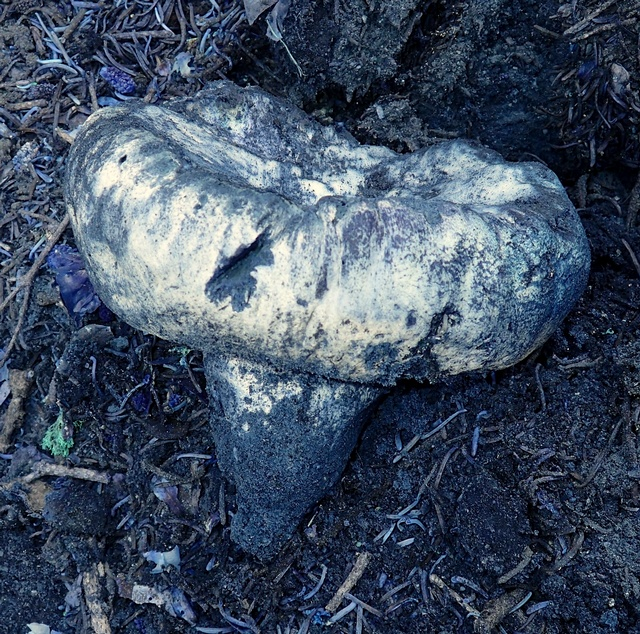

In [16]:
# Let's look at the first image as an example
image_row = 1
spark_single_img = df.limit(image_row+1).select("image").collect()[image_row]

# We can access image properties via spark_single_img.image.*
( spark_single_img.image.origin, spark_single_img.image.mode, spark_single_img.image.nChannels )# = spark_single_img

mode='RGBA' if (spark_single_img.image.nChannels == 4) else 'RGB'

img = Image.frombytes( 
    mode=mode, 
    data=bytes(spark_single_img.image.data), 
    size=[spark_single_img.image.width, spark_single_img.image.height]
)

display(img)

Resized one:

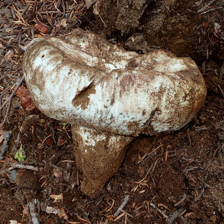

In [17]:
# An image with the correct color gamma (RGB) 
# and desired resolution (234x234)

resized_img = resize_img(spark_single_img.image, resize=True)
display(Image.frombytes(mode='RGB', data=bytes(resized_img), size=[224,224]))

In [18]:
# If we want to process the whole dataset

schema = StructType(df.select("image.*").schema.fields + [
    StructField("data_as_resized_array", ArrayType(IntegerType()), True),
    StructField("data_as_array", ArrayType(IntegerType()), True)
])

# Apply the resize function to each image
resized_df = df.select("image.*").mapInPandas(resize_image_udf, schema)

In [20]:

# resized_df.show(2) # it may take a while

We can check if the data contains a converted and a resized image:

In [ ]:
# row = resized_df.show(1).collect()[image_row]

# display(Image.frombytes(mode='RGB', data=bytes(row.data_as_array), size=[row.width,row.height]))

# display(Image.frombytes(mode='RGB', data=bytes(row.data_as_resized_array), size=[224,224]))

**Save** the resized images as output dataset.

In [ ]:
resized_df.write.save(OUTPUT_PATH, format="parquet", mode="append")

Check if the output dataset was saved successfully by running this command:
```
kubectl exec jupyter-spark-5789bbcc6c-pdqdt -- hdfs dfs -ls -h - /home/vsakovskaja-370052/

Found 4 items
drwxr-xr-x   - vsakovskaja-370052 vsakovskaja-370052          0 2023-06-21 14:13 /home/vsakovskaja-370052/data
-rw-r--r--   3 vsakovskaja-370052 vsakovskaja-370052      1.9 G 2023-06-20 11:20 /home/vsakovskaja-370052/data.zip
-rw-r--r--   3 vsakovskaja-370052 vsakovskaja-370052     34.8 M 2023-06-21 11:42 /home/vsakovskaja-370052/imagesAndNames.csv
drwxr-xr-x   - vsakovskaja-370052 vsakovskaja-370052          0 2023-06-21 14:49 /home/vsakovskaja-370052/output.parquet
```

In [ ]:
img2vec = F.udf(lambda x: DenseVector(ImageSchema.toNDArray(x).flatten()), VectorUDT())
df = df.withColumn('vecs', img2vec("image"))
df.show(10)

In [ ]:
# This will stop the Spark session

# spark.stop()